In [1]:
import os
import numpy as np
import pandas as pd
import sys
import json
import networkx as nx
import matplotlib.pyplot as plt
from venny4py.venny4py import *
import math
from glob import glob

# Add rpy2
%load_ext rpy2.ipython


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/traitlets/config/appl

In [2]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(ComplexHeatmap)
    library(cowplot)
    library(facefuns)
    library(factoextra)
    library(FactoMineR)
    library(ggh4x)
    library(ggraph)
    library(ggpubr)
    library(ggrain)
    library(ggridges)
    library(ggseg)
    library(ggsignif)
    library(ggVennDiagram)
    library(glue)
    library(igraph)
    library(LaCroixColoR)
    library(patchwork)
    library(RColorBrewer)
    library(rlist)
    library(scales)
    library(see)
    library(splitstackshape)
    library(tidyverse)
    library(VennDiagram) 
})


# Set cowplot theme
theme_set(theme_cowplot())

## How does each SPI perform in distinguishing (1) stimulus type and (2) relevance type, using averaged epochs compared across participants?

We can load the results from the logistic regression classification for (1) stimulus type and (2) relevance type):

In [3]:
# load pyspi SPI info
pyspi_SPI_info = pd.read_csv("../feature_extraction/pyspi_SPI_info.csv")

# Define path for derivatives directory
deriv_dir = "/Users/abry4213/data/Cogitate_MEG/derivatives"

# Initialize list for pyspi results
all_pyspi_res_averaged_epochs_list = []

# Load pyspi results -- update to where you have stored your pyspi results
pyspi_res_path_averaged = f"{deriv_dir}/time_series_features/averaged_epochs"

# Load classification res -- update to where you have stored your classification results
classification_res_path = f"{deriv_dir}/classification_results/across_participants"
averaged_stimulus_type_LR_classification_res = pd.read_csv(f"{classification_res_path}/comparing_between_stimulus_types_Logistic_Regression_classification_results.csv")
averaged_stimulus_type_SVM_classification_res = pd.read_csv(f"{classification_res_path}/comparing_between_stimulus_types_Linear_SVM_classification_results.csv")
averaged_relevance_type_LR_classification_res = pd.read_csv(f"{classification_res_path}/comparing_between_relevance_types_Logistic_Regression_classification_results.csv")
cross_task_LR_classification_res = pd.read_csv(f"{classification_res_path}/cross_task_Logistic_Regression_classification_results.csv")

# Add meta_ROI_pair column that combines the 'from' and 'to' meta-ROIs
averaged_stimulus_type_LR_classification_res["meta_ROI_pair"] = averaged_stimulus_type_LR_classification_res.meta_ROI_from + "__" + averaged_stimulus_type_LR_classification_res.meta_ROI_to
averaged_relevance_type_LR_classification_res["meta_ROI_pair"] = averaged_relevance_type_LR_classification_res.meta_ROI_from + "__" + averaged_relevance_type_LR_classification_res.meta_ROI_to
cross_task_LR_classification_res["meta_ROI_pair"] = cross_task_LR_classification_res.meta_ROI_from + "__" + cross_task_LR_classification_res.meta_ROI_to

# # Load in pyspi results
# # for pyspi_res_file in os.listdir(pyspi_res_path_averaged):
# for pyspi_res_file in glob(f"{pyspi_res_path_averaged}/*.csv"):
#     pyspi_res_averaged = pd.read_csv(pyspi_res_file)
#     all_pyspi_res_averaged_epochs_list.append(pyspi_res_averaged)

# # Concatenate pyspi results
# all_pyspi_res_averaged_epochs = pd.concat(all_pyspi_res_averaged_epochs_list)

## What is the overall distribution in SPI performance per classification task?

Before diving into any specific result, let's first see the distribution in performance across all SPIs per stimulus task classification problem (e.g., 'Face' vs. 'Object') by meta-ROI pair (e.g., 'GNWT' to 'CS')

In [64]:
%%R -i averaged_stimulus_type_LR_classification_res -w 900 -h 650 

# Find limits for the y-axis common to both relevance types
y_max <- averaged_stimulus_type_LR_classification_res %>%
                filter(accuracy > 0.5, 
                       stimulus_combo != "('face', 'non-face')",
                       relevance_type==this_rel, 
                       meta_ROI_pair %in% c("Category_Selective__V1_V2",
                                             "V1_V2__Category_Selective",
                                             "Category_Selective__Prefrontal_Cortex",
                                             "Prefrontal_Cortex__Category_Selective",
                                             "Category_Selective__IPS",
                                             "IPS__Category_Selective"
                                           )) %>%
                ungroup() %>%
                filter(accuracy == max(accuracy)) %>% 
                distinct(accuracy) %>% 
                pull(accuracy)

plot_list <- list()

# Create raincloud plot visualization for all stimulus type classification results
for (this_rel in unique(averaged_stimulus_type_LR_classification_res$relevance_type)) {
    relevance_plot <- averaged_stimulus_type_LR_classification_res %>% 
        # Filter accuracy to >50% for visualization purposes
        filter(accuracy > 0.5, relevance_type==this_rel, meta_ROI_pair %in% c("Category_Selective__V1_V2",
                                                                                "V1_V2__Category_Selective",
                                                                                "Category_Selective__Prefrontal_Cortex",
                                                                                "Prefrontal_Cortex__Category_Selective",
                                                                                "Category_Selective__IPS",
                                                                                "IPS__Category_Selective"
                                                                            )) %>%
        mutate(accuracy = 100*accuracy) %>%
        rowwise() %>%
        # Want a specific order for the meta-ROI pair in the plot
        mutate(meta_ROI_pair = factor(meta_ROI_pair, levels = c("Category_Selective__V1_V2",
                                                                "V1_V2__Category_Selective",
                                                                "Category_Selective__Prefrontal_Cortex",
                                                                "Prefrontal_Cortex__Category_Selective",
                                                                "Category_Selective__IPS",
                                                                "IPS__Category_Selective"
                                                            )))  %>% 
        mutate(stimulus_combo = factor(stimulus_combo, levels = c("('face', 'letter')", "('face', 'object')",  
                                                                "('false', 'face')",  "('false', 'letter')",
                                                                "('letter', 'object')", "('false', 'object')"))) %>%
        filter(!is.na(stimulus_combo)) %>%
        ggplot(data=., mapping=aes(x=stimulus_presentation, y=accuracy, fill=meta_ROI_pair)) +
        # Create half violins colored by meta-ROI pair and stimulus presentation period
        geom_violinhalf(scale="width", color="black", position = position_dodge(width = 2), width=1)  +
        geom_point(aes(color = meta_ROI_pair), position = position_jitter(width = 0.075, height=0),
                                size = 1.75, alpha=0.6, stroke=0) +
        stat_summary(color="black", fun="mean", geom="crossbar", width=0.2, linewidth=0.3, 
                show.legend=FALSE, position = position_dodge(width=1.4)) +
        facet_grid(meta_ROI_pair ~ stimulus_combo, scales="free", switch="y") + 
        theme(legend.position = "bottom") +
        scale_x_discrete(expand = c(0, 0)) +
        scale_y_continuous(expand = c(0, 0), limits = c(50, 100*y_max), breaks=c(50, 55, 60, 65)) +
        scale_fill_manual(values = c(Category_Selective__V1_V2 = "#f8766d",
                                     V1_V2__Category_Selective = "#de8c00",
                                     Category_Selective__Prefrontal_Cortex = "#b79f00",
                                     Prefrontal_Cortex__Category_Selective = "#7caf00",
                                     Category_Selective__IPS = "#f564e3",
                                     IPS__Category_Selective = "#ff64b0")) +
        scale_color_manual(values = c(Category_Selective__V1_V2 = "#f8766d",
                                     V1_V2__Category_Selective = "#de8c00",
                                     Category_Selective__Prefrontal_Cortex = "#b79f00",
                                     Prefrontal_Cortex__Category_Selective = "#7caf00",
                                     Category_Selective__IPS = "#f564e3",
                                     IPS__Category_Selective = "#ff64b0")) +
        xlab("Stimulus presentation period") +
        ylab("Cross-validated accuracy by SPI (%)") +
        labs(fill="Stimulus Presentation", color="Stimulus Presentation") +
        theme(strip.background = element_blank(),
            strip.placement="outside",
            legend.position="none",
            panel.spacing = unit(0.5, "lines"),
            axis.text.x = element_text(angle=45, hjust=1)) +
        coord_flip()

    plot_list[[this_rel]] <- relevance_plot
}

wrap_plots(plotlist = plot_list, ncol = 1)
# ggsave(glue('../plots/inter_subject_classification/Stimulus_wise_classification_performance_by_meta_ROI_pair_across_relevance.svg'), width=9, height=11, units='in', dpi=300)


### How about cross-task distribution?

In [65]:
%%R -i cross_task_LR_classification_res -w 900 -h 650 

# Create raincloud plot visualization for all stimulus type classification results
for (cross_task_direction in unique(cross_task_LR_classification_res$cross_task_direction)) {
    cross_task_LR_classification_res %>% 
        # Filter accuracy to >50% for visualization purposes
        filter(accuracy > 0.5, cross_task_direction==cross_task_direction, meta_ROI_pair %in% c("Category_Selective__V1_V2",
                                                                                                "V1_V2__Category_Selective",
                                                                                                "Category_Selective__Prefrontal_Cortex",
                                                                                                "Prefrontal_Cortex__Category_Selective",
                                                                                                "Category_Selective__IPS",
                                                                                                "IPS__Category_Selective")) %>%
        mutate(accuracy = 100*accuracy) %>%
        rowwise() %>%
        # Want a specific order for the meta-ROI pair in the plot
        mutate(meta_ROI_pair = factor(meta_ROI_pair, levels = c("Category_Selective__V1_V2",
                                                                "V1_V2__Category_Selective",
                                                                "Category_Selective__Prefrontal_Cortex",
                                                                "Prefrontal_Cortex__Category_Selective",
                                                                "Category_Selective__IPS",
                                                                "IPS__Category_Selective"
                                                            )))  %>% 
        mutate(stimulus_combo = factor(stimulus_combo, levels = c("('face', 'letter')", "('face', 'object')",  
                                                                "('false', 'face')",  "('false', 'letter')",
                                                                "('letter', 'object')", "('false', 'object')"))) %>%
        filter(!is.na(stimulus_combo)) %>%
        ggplot(data=., mapping=aes(x=stimulus_presentation, y=accuracy, fill=meta_ROI_pair)) +
        # Create half violins colored by meta-ROI pair and stimulus presentation period
        geom_violinhalf(scale="width", color="black", position = position_dodge(width = 2), width=1)  +
        geom_point(aes(color = meta_ROI_pair), position = position_jitter(width = 0.075, height=0),
                                size = 1.75, alpha=0.6, stroke=0) +
        stat_summary(color="black", fun="mean", geom="crossbar", width=0.2, linewidth=0.3, 
                show.legend=FALSE, position = position_dodge(width=1.4)) +
        facet_grid(meta_ROI_pair ~ stimulus_combo, scales="free", switch="y") + 
        theme(legend.position = "bottom") +
        scale_x_discrete(expand = c(0, 0)) +
        xlab("Stimulus presentation period") +
        ylab("Cross-validated accuracy by SPI (%)") +
        labs(fill="Stimulus Presentation", color="Stimulus Presentation") +
        theme(strip.background = element_blank(),
            strip.placement="outside",
            legend.position="none",
            panel.spacing = unit(0.5, "lines"),
            axis.text.x = element_text(angle=45, hjust=1)) +
        coord_flip()

    ggsave(glue('../plots/inter_subject_classification/Stimulus_wise_classification_performance_by_meta_ROI_pair_{cross_task_direction}.svg'), width=10, height=12, units='in', dpi=300)
}

## Examine the top-performing SPI for each ROI pair, zooming in on the top 4

In [68]:
%%R -i averaged_stimulus_type_LR_classification_res -o top_res

# Line plot showing the maximum cross-validated accuracy for each 
# stimulus comparison (x-axis) and meta-ROI pair (colored lines)
top_res <- averaged_stimulus_type_LR_classification_res %>% 
    group_by(meta_ROI_pair, stimulus_combo) %>% 
    filter(meta_ROI_pair %in% c("Category_Selective__V1_V2",
                                "V1_V2__Category_Selective",
                                "Category_Selective__Prefrontal_Cortex",
                                "Prefrontal_Cortex__Category_Selective",
                                "Category_Selective__IPS",
                                "IPS__Category_Selective")) %>%
    # Want a specific order for the meta-ROI pair in the plot
    mutate(meta_ROI_pair = factor(meta_ROI_pair, levels = c("Category_Selective__V1_V2",
                                                            "V1_V2__Category_Selective",
                                                            "Category_Selective__Prefrontal_Cortex",
                                                            "Prefrontal_Cortex__Category_Selective",
                                                            "Category_Selective__IPS",
                                                            "IPS__Category_Selective")),
            stimulus_combo = str_replace_all(stimulus_combo, "False", "false"))  %>% 
    # Find maximum accuracy
    filter(accuracy==max(accuracy,na.rm=T)) %>%
    ungroup() %>%
    mutate(accuracy=100*accuracy,
           stimulus_combo = factor(stimulus_combo, 
                                   levels = c("('face', 'object')",  
                                              "('false', 'face')",
                                              "('face', 'letter')", 
                                              "('letter', 'object')", 
                                              "('false', 'object')", 
                                              "('false', 'letter')"))) %>% 
    filter(!is.na(stimulus_combo)) %>%
    group_by(meta_ROI_pair) %>%
    mutate(is_max = ifelse(accuracy==max(accuracy,na.rm=T), "Max", "Not Max"),
           max_label = ifelse(is_max=="Max", round(accuracy, 1), NA_real_)) 
                                              
top_res %>%
    ggplot(data=., mapping=aes(x=stimulus_combo, y=accuracy, color=meta_ROI_pair, group=meta_ROI_pair)) +
    geom_line(linewidth=1.25) +
    geom_point(aes(size=is_max)) + 
    scale_size_manual(values=c("Not Max" = 0, "Max" = 4)) +
    geom_text(aes(label=max_label), hjust=0.5, vjust=-1.25, size=4.5) +
    xlab("Stimulus comparison") +
    ylab("Cross-validated accuracy (%)") +
    # Set y-axis breaks to only 60 and 65
    # scale_y_continuous(breaks=c(60,65)) +
    scale_x_discrete(expand = c(0.1, 0)) +
    scale_fill_manual(values = c(Category_Selective__V1_V2 = "#f8766d",
                                     V1_V2__Category_Selective = "#de8c00",
                                     Category_Selective__Prefrontal_Cortex = "#b79f00",
                                     Prefrontal_Cortex__Category_Selective = "#7caf00",
                                     Category_Selective__IPS = "#f564e3",
                                     IPS__Category_Selective = "#ff64b0")) +
        scale_color_manual(values = c(Category_Selective__V1_V2 = "#f8766d",
                                     V1_V2__Category_Selective = "#de8c00",
                                     Category_Selective__Prefrontal_Cortex = "#b79f00",
                                     Prefrontal_Cortex__Category_Selective = "#7caf00",
                                     Category_Selective__IPS = "#f564e3",
                                     IPS__Category_Selective = "#ff64b0")) +
    scale_y_continuous(expand=c(0.25,0)) +
    facet_grid(meta_ROI_pair ~ ., scales="free_x") +
    theme(legend.position="none", strip.background = element_blank(),
          strip.placement="outside", strip.text = element_blank(),
          panel.spacing = unit(0.25, "lines"))
ggsave('../plots/inter_subject_classification/Max_performance_for_each_stim_combo_by_meta_ROI_pair.svg', width=4.5, height=9, units='in', dpi=300)

In addition: Warning messages:
1: No shared levels found between `names(values)` of the manual scale and the
data's fill values. 
2: Removed 34 rows containing missing values or values outside the scale range
(`geom_text()`). 


## Euler diagrams for SPIs greater than 60% accuracy

In [4]:
# Filter to accuracy > 60%
face_non_face = "('face', 'non-face')"
averaged_stimulus_type_LR_classification_res_above_60 = averaged_stimulus_type_LR_classification_res.query("accuracy >= 0.6 & stimulus_combo != @face_non_face & meta_ROI_pair in ['Category_Selective__V1_V2', 'V1_V2__Category_Selective', 'Category_Selective__Prefrontal_Cortex', 'Prefrontal_Cortex__Category_Selective', 'Category_Selective__IPS', 'IPS__Category_Selective']")

# For each ROI (from or to, doesn't matter), find all of the unique SPIs that have accuracy > 60%
unique_SPIs_from = averaged_stimulus_type_LR_classification_res_above_60.groupby("meta_ROI_from").SPI.unique().reset_index()
unique_SPIs_to = averaged_stimulus_type_LR_classification_res_above_60.groupby("meta_ROI_to").SPI.unique().reset_index()

# Convert from list-column to long format
unique_SPIs_from_long = unique_SPIs_from.explode("SPI")
unique_SPIs_to_long = unique_SPIs_to.explode("SPI")

In [5]:
%%R -i unique_SPIs_from_long

SPIs_from_venn <- split(unique_SPIs_from_long, unique_SPIs_from_long$meta_ROI_from)
SPIs_from_venn <- lapply(SPIs_from_venn, function(x) x %>% pull(SPI))
SPIs_from_venn <- SPIs_from_venn[c("V1_V2", "IPS", "Prefrontal_Cortex")]

venn_from <- Venn(SPIs_from_venn)
data_from <- process_data(venn_from, shape_id = "301f")

ggplot() +
  # 1. region count layer
  geom_polygon(aes(X, Y, fill = count, group = id), 
          data = venn_regionedge(data_from)) +
  # 2. set edge layer
  geom_path(aes(X, Y, group = id), 
          data = venn_setedge(data_from), 
          show.legend = FALSE) +
  # 3. set label layer
  geom_text(aes(X, Y, label = name), 
               data = venn_setlabel(data_from)) +
  # 4. region label layer
  geom_text(aes(X, Y, label = count), size=6,
                data = venn_regionlabel(data_from)) +
  coord_equal() +
  theme_void() +
  scale_fill_distiller(palette = "Greens", direction = 1) +
  theme(legend.position="none")
  
ggsave("../plots/inter_subject_classification/Top_SPIs_to_CS_Euler.svg", width=4.5, height=4.5, units='in', dpi=300)

/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


In [6]:
%%R -i unique_SPIs_to_long

SPIs_to_venn <- split(unique_SPIs_to_long, unique_SPIs_to_long$meta_ROI_to)
SPIs_to_venn <- lapply(SPIs_to_venn, function(x) x %>% pull(SPI))
SPIs_to_venn <- SPIs_to_venn[c("V1_V2", "IPS", "Prefrontal_Cortex")]

venn_to <- Venn(SPIs_to_venn)
data_to <- process_data(venn_to, shape_id = "301f")

ggplot() +
  # 1. region count layer
  geom_polygon(aes(X, Y, fill = count, group = id), 
          data = venn_regionedge(data_to)) +
  # 2. set edge layer
  geom_path(aes(X, Y, group = id), 
          data = venn_setedge(data_to), 
          show.legend = FALSE) +
  # 3. set label layer
  geom_text(aes(X, Y, label = name), 
               data = venn_setlabel(data_to)) +
  # 4. region label layer
  geom_text(aes(X, Y, label = count), size=6, 
                data = venn_regionlabel(data_to)) +
  coord_equal() +
  theme_void() +
  scale_fill_distiller(palette = "Purples", direction = 1) +
  labs(fill="# SPIs") +
  theme(legend.position="none")

ggsave("../plots/inter_subject_classification/Top_SPIs_from_CS_Euler.svg", width=4.5, height=4.5, units='in', dpi=300)

/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


### Which SPI is at the center of both Euler diagrams?

In [7]:
%%R -i unique_SPIs_from_long,unique_SPIs_to_long

SPI_all_four_from <- unique_SPIs_from_long %>% 
    filter(meta_ROI_from %in% c("V1_V2", "IPS", "Prefrontal_Cortex")) %>%
    group_by(SPI) %>% 
    count() %>% 
    ungroup() %>% 
    filter(n == 3)

SPI_all_four_to <- unique_SPIs_to_long %>%
    filter(meta_ROI_to %in% c("V1_V2", "IPS", "Prefrontal_Cortex")) %>%
    group_by(SPI) %>% 
    count() %>% 
    ungroup() %>% 
    filter(n == 3)

print(glue("SPIs that are present in all pathways to Category-Selective: {SPI_all_four_from$SPI}"))
print(glue("SPIs that are present in all pathways from Category-Selective: {SPI_all_four_to$SPI}"))

SPIs that are present in all pathways to Category-Selective: bary-sq_dtw_max
SPIs that are present in all pathways to Category-Selective: bary-sq_sgddtw_max
SPIs that are present in all pathways to Category-Selective: bary-sq_softdtw_max
SPIs that are present in all pathways to Category-Selective: reci
SPIs that are present in all pathways from Category-Selective: bary-sq_dtw_max
SPIs that are present in all pathways from Category-Selective: bary-sq_sgddtw_max
SPIs that are present in all pathways from Category-Selective: bary-sq_softdtw_max


/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


## What type(s) of SPIs perform the best (1) by meta-ROI pair and (2) by stimulus type comparison?

Since each SPI belongs to a particular literature category (e.g., 'spectral' or 'information theory'), we can compare the composition of the top-performing (>62% accuracy) SPIs in each context -- first, by meta-ROI pair:

In [8]:
# Merge SPI info with results
unique_SPIs_from_long = unique_SPIs_from_long.merge(pyspi_SPI_info, how='left', on='SPI')
unique_SPIs_to_long = unique_SPIs_to_long.merge(pyspi_SPI_info, how='left', on='SPI')

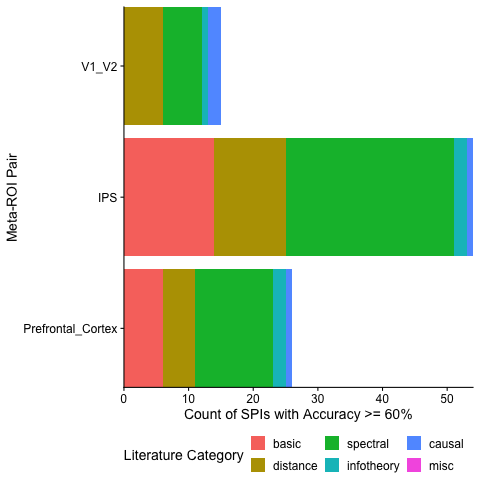

In [9]:
%%R -i unique_SPIs_from_long 

# A) By meta-ROI pair, stacked bar chart showing the relative composition of SPIs with accuracy > 65%
unique_SPIs_from_long %>% 
    filter(meta_ROI_from %in% c("V1_V2", "IPS", "Prefrontal_Cortex")) %>%
    mutate(Literature_category = factor(Literature_category, levels = c("basic", "distance", "spectral", 
                                                                        "infotheory", "causal", "misc")),
            meta_ROI_from = factor(meta_ROI_from, levels = rev(c("V1_V2", "IPS", "Prefrontal_Cortex")))) %>%
    ggplot(data=., mapping=aes(x=meta_ROI_from, fill=Literature_category)) +
    # Reverse the order in which the bars are stacked
    geom_bar(show.legend = TRUE, position = position_stack(reverse = TRUE)) +
    coord_flip() +
    xlab("Meta-ROI Pair") +
    scale_fill_discrete(drop=FALSE) +
    # Keep all factor levels in legend
    guides(fill=guide_legend(title="Literature Category")) +
    scale_y_continuous(expand=c(0,0)) +
    scale_x_discrete(expand=c(0,0)) +
    ylab("Count of SPIs with Accuracy >= 60%") +
    theme(legend.position = "bottom")
# ggsave('../plots/inter_subject_classification/ROI_to_CS_top_SPI_categories.svg', width=5, height=3.5, units='in', dpi=300)

Joining with `by = join_by(SPI, Directionality, Literature_category, Module)`


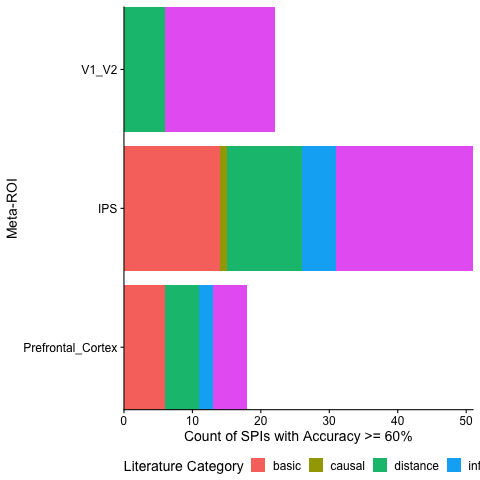

In [10]:
%%R -i unique_SPIs_to_long,pyspi_SPI_info 

# A) By meta-ROI pair, stacked bar chart showing the relative composition of SPIs with accuracy > 65%
unique_SPIs_to_long %>% 
    left_join(., pyspi_SPI_info %>% mutate(Literature_category = factor(Literature_category,
                                                                        levels = c("basic", "distance", "spectral", 
                                                                                   "infotheory", "causal", "misc")))) %>% 
        mutate(meta_ROI_to = factor(meta_ROI_to, levels = rev(c("Category_Selective", "V1_V2", "IPS", "Prefrontal_Cortex")))) %>%
    filter(meta_ROI_to %in% c("V1_V2", "IPS", "Prefrontal_Cortex")) %>%
    ggplot(data=., mapping=aes(x=meta_ROI_to, fill=Literature_category)) +
    # Reverse the order in which the bars are stacked
    geom_bar(show.legend = TRUE, position = position_stack(reverse = TRUE)) +
    coord_flip() +
    xlab("Meta-ROI") +
    scale_fill_discrete(drop=FALSE) +
    # Keep all factor levels in legend
    guides(fill=guide_legend(title="Literature Category")) +
    scale_y_continuous(expand=c(0,0)) +
    scale_x_discrete(expand=c(0,0)) +
    ylab("Count of SPIs with Accuracy >= 60%") +
    theme(legend.position = "bottom")
# ggsave('../plots/inter_subject_classification/ROI_from_CS_top_SPI_categories.svg', width=5, height=3.5, units='in', dpi=300)

## What is the max performance by SPI across all analyses?

In [16]:
%%R -i averaged_stimulus_type_LR_classification_res,pyspi_SPI_info

averaged_stimulus_type_LR_classification_res %>% 
       filter(meta_ROI_pair %in% c("Category_Selective__V1_V2",
              "V1_V2__Category_Selective",
              "Category_Selective__Prefrontal_Cortex",
              "Prefrontal_Cortex__Category_Selective",
              "Category_Selective__IPS",
              "IPS__Category_Selective"),
           stimulus_combo != "('face', 'non-face')") %>%
    group_by(SPI) %>% 
    filter(accuracy==max(accuracy, na.rm=T)) %>%
    ungroup() %>% 
    distinct(SPI, accuracy) %>% 
    filter(accuracy > 0.5) %>% 
    left_join(., pyspi_SPI_info) %>% 
    mutate(SPI = fct_reorder(SPI, accuracy, .desc=F),
           Literature_category = factor(Literature_category, 
                                        levels = c("basic", "distance", "spectral", 
                                        "infotheory", "causal", "misc")),
           SPI_label = ifelse(str_detect(SPI, "bary-sq_.*_max"), "*", NA_character_)) %>%
    ggplot(data=., mapping=aes(x=SPI, y=100*accuracy)) +
    geom_point(aes(color=Literature_category), alpha=0.8, stroke=0) +
    # Add a line from the point to the x-axis
    geom_segment(aes(xend=SPI, yend=50, color=Literature_category)) +
    geom_line() +
    geom_text(aes(label=SPI_label), size=4) +
    ylab("Maximum Accuracy (%)") +
    coord_flip() +
    scale_y_continuous(expand=c(0,0)) +
    theme(axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          legend.position="none")
ggsave('../plots/inter_subject_classification/Max_classification_performance_by_SPI_category.svg', width=3, height=8, units='in', dpi=300)

Joining with `by = join_by(SPI)`
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


In addition: Warning message:
Removed 241 rows containing missing values or values outside the scale range
(`geom_text()`). 


# Task relevance analysis

In [ ]:
%%R -i relevance_type_classification_res -w 900 -h 650 

# Create raincloud plot visualization for all stimulus type classification results
relevance_type_classification_res %>% 
    # Filter accuracy to >50% for visualization purposes
    filter(accuracy > 0.5) %>%
    mutate(accuracy = 100*accuracy, 
           stimulus_presentation = factor(stimulus_presentation, levels = c("on", "off"))) %>%
    rowwise() %>%
    mutate(sp_and_roi = paste0(meta_ROI_pair, "__", stimulus_presentation)) %>%
    mutate(sp_and_roi = factor(sp_and_roi, levels = rev(c("IIT_Category_Selective__on",
                                                        "IIT_Category_Selective__off",
                                                        "Category_Selective_IIT__on",
                                                        "Category_Selective_IIT__off",
                                                        "Category_Selective_GNWT__on",
                                                        "Category_Selective_GNWT__off",
                                                        "GNWT_Category_Selective__on",
                                                        "GNWT_Category_Selective__off")))) %>%
    ggplot(data=., mapping=aes(x=sp_and_roi, y=accuracy, fill=sp_and_roi)) +
    # Create half violins colored by meta-ROI pair and stimulus presentation period
    geom_violinhalf(scale="width", color="black", position = position_dodge(width = 1), width=1)  +
    geom_point(aes(color = sp_and_roi), position = position_jitter(width = 0.075, height=0),
                            size = 1.5, alpha=0.6, stroke=0) +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.2, linewidth=0.3, 
            show.legend=FALSE, position = position_dodge(width=1.4)) +
    # Custom color lookup table for (1) meta-ROI pair and (2) stimulus presentation period
    scale_color_manual(values=c("IIT_Category_Selective__on" = "#9F70CE",
                                "IIT_Category_Selective__off" = "#D9B7FA",
                                "Category_Selective_IIT__on" = "#3982C4",
                                "Category_Selective_IIT__off" = "#9BCEFB",
                                "Category_Selective_GNWT__on" = "#8EB03A",
                                "Category_Selective_GNWT__off" = "#C6D79D",
                                "GNWT_Category_Selective__on" = "#f55c69",
                                "GNWT_Category_Selective__off" = "#f8949c")) +
    scale_fill_manual(values=c("IIT_Category_Selective__on" = "#9F70CE",
                                "IIT_Category_Selective__off" = "#D9B7FA",
                                "Category_Selective_IIT__on" = "#3982C4",
                                "Category_Selective_IIT__off" = "#9BCEFB",
                                "Category_Selective_GNWT__on" = "#8EB03A",
                                "Category_Selective_GNWT__off" = "#C6D79D",
                                "GNWT_Category_Selective__on" = "#f55c69",
                                "GNWT_Category_Selective__off" = "#f8949c")) +
    theme(legend.position = "bottom") +
    scale_x_discrete(expand = c(0, 0))+
    xlab("Meta-ROI Pair") +
    ylab("Cross-validated accuracy by SPI (%)") +
    labs(fill="Stimulus Presentation", color="Stimulus Presentation") +
    theme(strip.background = element_blank(),
          legend.position="none",
          axis.text.x = element_text(angle=45, hjust=1)) +
    coord_flip()

# ggsave('plots/Relevance_type_classification_performance_by_meta_ROI_pair.svg', width=4.5, height=6, units='in', dpi=300)

In [5]:
averaged_relevance_type_LR_classification_res.head()

,SPI,meta_ROI_from,meta_ROI_to,stimulus_presentation,comparison,accuracy,meta_ROI_pair
0,cov_EmpiricalCovariance,Category_Selective,IPS,on,Relevant non-target vs. Irrelevant,0.533750,Category_Selective__IPS
1,cov_GraphicalLasso,Category_Selective,IPS,on,Relevant non-target vs. Irrelevant,0.533611,Category_Selective__IPS
2,cov_GraphicalLassoCV,Category_Selective,IPS,on,Relevant non-target vs. Irrelevant,0.521528,Category_Selective__IPS
3,cov_LedoitWolf,Category_Selective,IPS,on,Relevant non-target vs. Irrelevant,0.536389,Category_Selective__IPS
4,cov_OAS,Category_Selective,IPS,on,Relevant non-target vs. Irrelevant,0.537778,Category_Selective__IPS


In [16]:
%%R -i averaged_relevance_type_LR_classification_res -w 900 -h 650 

averaged_relevance_type_LR_classification_res %>% 
    group_by(SPI, meta_ROI_from, meta_ROI_to, meta_ROI_pair, stimulus_presentation) %>%
    summarise(accuracy = mean(accuracy)) %>%
    # Filter accuracy to >50% for visualization purposes
    filter(accuracy > 0.5) %>%
    mutate(accuracy = 100*accuracy) %>%
    rowwise() %>%
    # Want a specific order for the meta-ROI pair in the plot
    mutate(meta_ROI_pair = factor(meta_ROI_pair, levels = c("V1_V2__Category_Selective",
                                                    "Category_Selective__V1_V2",
                                                    "Category_Selective__IPS",
                                                    "IPS__Category_Selective",
                                                    "IPS__Prefrontal_Cortex",
                                                    "Prefrontal_Cortex__IPS",
                                                    "Prefrontal_Cortex__V1_V2",
                                                    "V1_V2__Prefrontal_Cortex",
                                                    "V1_V2__IPS",
                                                    "IPS__V1_V2",
                                                    "Prefrontal_Cortex__Category_Selective",
                                                    "Category_Selective__Prefrontal_Cortex"))) %>%
    ggplot(data=., mapping=aes(x=meta_ROI_pair, y=accuracy, fill=meta_ROI_pair)) +
    # Create half violins colored by meta-ROI pair and stimulus presentation period
    geom_violinhalf(scale="width", color="black", position = position_dodge(width = 2), width=1)  +
    geom_point(aes(color = meta_ROI_pair), position = position_jitter(width = 0.075, height=0),
                            size = 1.75, alpha=0.6, stroke=0) +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.2, linewidth=0.3, 
            show.legend=FALSE, position = position_dodge(width=1.4)) +
    facet_grid(meta_ROI_pair ~ stimulus_presentation, scales="free_y", switch="y") + 
    theme(legend.position = "bottom") +
    scale_x_discrete(expand = c(0, 0)) +
    ylab("Cross-validated accuracy by SPI (%)") +
    labs(fill="Stimulus Presentation", color="Stimulus Presentation") +
    theme(strip.background = element_blank(),
        strip.placement="outside",
        legend.position="none",
        panel.spacing = unit(0.5, "lines"),
        strip.text.y = element_blank(),
        strip.text.x = element_text(size=14, face="bold"),
        axis.text = element_text(size=14)) +
    coord_flip()

# ggsave(glue('../plots/inter_subject_classification/Relevance_type_classification_performance_by_meta_ROI_pair.svg'), width=8, height=8, units='in', dpi=300)

`summarise()` has grouped output by 'SPI', 'meta_ROI_from', 'meta_ROI_to',
'meta_ROI_pair'. You can override using the `.groups` argument.
